In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy.spatial
import pandas as pd

import sklearn.decomposition
import matplotlib.pyplot as plt
# import keras
from sklearn import preprocessing
from sklearn.decomposition import PCA
# %matplotlib inline
# Dimension reduction and clustering libraries
# import umap
# import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.model_selection import LeaveOneOut,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import pairwise_distances,mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from utils.readProfiles import readMergedProfiles
from utils.pred_models import *
from utils.saveAsNewSheetToExistingFile import saveAsNewSheetToExistingFile

# from utils import networksEvol, tsne, readProfiles
# import umap

In [2]:
pd.__version__

'1.1.1'

## MoA Prediction:
- Data Fusion Methods:
    - Early Fusion: simple concatenation
    - Late Fusion: desision probabilty average
    - RGCCA

### Paths

In [1]:
procProf_dir='/home/ubuntu/datasetsbucket/Rosetta-GE-CP/'
# procProf_dir='/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/'
metadata_dir='/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/metadata/'
results_dir='../results/'

### Read GE and CP profiles 

In [4]:
################################################
# dataset options: 'CDRP' , 'LUAD', 'TAORF', 'LINCS', 'CDRP-bio'
dataset='CDRP-bio'


################################################
# CP Profile Type options: 'augmented' , 'normalized', 'normalized_variable_selected'
profileType='normalized_variable_selected'
profTypeAbbrev=''.join([s[0] for s in profileType.split('_')])

################################################
# filtering to compounds which have high replicates for both GE and CP datasets
# highRepOverlapEnabled=0
# 'highRepUnion','highRepOverlap',''
filter_perts='highRepUnion'


################################################
pertColName='PERT'
if filter_perts:
    f='filt'
else:
    f=''

mergProf_treatLevel,cp_features,l1k_features = \
read_paired_treatment_level_profiles(procProf_dir,dataset,profileType,filter_perts,1)

moa_col='Metadata_MoA'

##################################
if dataset=='LINCS':
    mergProf_treatLevel[moa_col]=mergProf_treatLevel['Metadata_moa']
    mergProf_treatLevel.loc[mergProf_treatLevel['Metadata_moa'].isnull(),moa_col]=\
    mergProf_treatLevel.loc[mergProf_treatLevel['Metadata_moa'].isnull(),'moa'].str.lower()    
    mergProf_treatLevel['Compounds']=mergProf_treatLevel['PERT'].str[0:13]
    
elif dataset=='CDRP-bio':
    mergProf_treatLevel[moa_col]=mergProf_treatLevel['Metadata_moa'].str.lower()
    mergProf_treatLevel['Compounds']=mergProf_treatLevel['PERT'].str[0:13]

# mergProf_repLevel,mergProf_treatLevel,l1k_features,cp_features,pertColName=readMergedProfiles(dataset,profileType,nRep)
# cp_features,l1k_features=cp_features.tolist(),l1k_features.tolist()
# mergProf_repLevel['Compounds']=mergProf_repLevel['PERT'].str[0:13]

if profileLevel=='replicate':
    l1k=mergProf_repLevel[[pertColName]+l1k_features]
    cp=mergProf_repLevel[[pertColName]+cp_features]
elif profileLevel=='treatment':
    l1k=mergProf_treatLevel[[pertColName,'Compounds',moa_col]+l1k_features]
    cp=mergProf_treatLevel[[pertColName,'Compounds',moa_col]+cp_features]


scaler_ge = preprocessing.StandardScaler()
scaler_cp = preprocessing.StandardScaler()
l1k_scaled=l1k.copy()
l1k_scaled[l1k_features] = scaler_ge.fit_transform(l1k[l1k_features].values)
cp_scaled=cp.copy()
cp_scaled[cp_features] = scaler_cp.fit_transform(cp[cp_features].values.astype('float64'))


if 1:
    cp_scaled[cp_features] =preprocessing.MinMaxScaler(feature_range=(0, 1)).fit_transform(cp_scaled[cp_features].values)   
    l1k_scaled[l1k_features] =preprocessing.MinMaxScaler(feature_range=(0, 1)).fit_transform(l1k_scaled[l1k_features].values)           


# if dataset=='LINCS':
merged_scaled=pd.concat([cp_scaled, l1k_scaled], axis=1)
merged_scaled = merged_scaled.loc[:,~merged_scaled.columns.duplicated()]    
merged_scaled['Compounds']=merged_scaled['PERT'].str[0:13]
# elif dataset=='CDRP-bio':
#     l1k_scaled[moa_col]=cp_scaled[moa_col] # for CDRP
#     merged_scaled=pd.merge(cp_scaled, l1k_scaled, how='inner',on=['PERT',moa_col]); # for CDRP


#################### keep MOAs with more than "nSamplesMOA" compounds in their class

nSamplesMOA=4

nSamplesforEachMOAclass=mergProf_treatLevel.groupby(['Compounds']).sample(1).groupby([moa_col]).size().\
reset_index().rename(columns={0:'size'}).sort_values(by=['size'],ascending=False).reset_index(drop=True)


nSamplesforEachMOAclass2=mergProf_treatLevel.groupby([moa_col]).size().reset_index().rename(columns={0:'size'}).sort_values(by=['size'],ascending=False).reset_index(drop=True)

listOfSelectedMoAs=nSamplesforEachMOAclass[nSamplesforEachMOAclass['size']>nSamplesMOA][moa_col].tolist()
print('If we filter to MoAs which have more than',nSamplesMOA+1,' compounds in their category, ',\
      len(listOfSelectedMoAs),' out of ',nSamplesforEachMOAclass.shape[0] ,' MoAs remain.')



multi_label_MoAs=[l for l in listOfSelectedMoAs if '|' in l]
print('There are ',len(listOfSelectedMoAs),'MoA categories, which out of them ',len(multi_label_MoAs),\
      ' have multi labels and is removed')

listOfSelectedMoAs=[ele for ele in listOfSelectedMoAs if ele not in multi_label_MoAs]

le = preprocessing.LabelEncoder()
le.fit(listOfSelectedMoAs)

# IDs4filteredMOAs=mergProf_treatLevel[mergProf_treatLevel[moa_col].isin(listOfSelectedMoAs)][pertColName].unique().tolist()

rgcca_factors_cp=pd.read_csv("./results_CP_GE_cdrpbio/factors_rgcca_cp.txt",sep="\t").reset_index(drop=True)
rgcca_factors_ge=pd.read_csv("./results_CP_GE_cdrpbio/factors_rgcca_ge.txt",sep="\t").reset_index(drop=True).add_suffix('_ge')
rgcca_concat=pd.concat([rgcca_factors_cp,rgcca_factors_ge],axis=1)

filteredMOAs=merged_scaled[merged_scaled[moa_col].isin(listOfSelectedMoAs)].reset_index(drop=True)
data4eval=[[cp_scaled[cp_scaled[moa_col].isin(listOfSelectedMoAs)].reset_index(drop=True),cp_features],\
           [l1k_scaled[l1k_scaled[moa_col].isin(listOfSelectedMoAs)].reset_index(drop=True),l1k_features],\
           [filteredMOAs,cp_features+l1k_features],\
           [rgcca_factors_cp,rgcca_factors_cp.columns.tolist()],\
           [rgcca_factors_ge,rgcca_factors_ge.columns.tolist()],\
           [rgcca_concat,rgcca_concat.columns.tolist()]]


filteredMOAs['Metadata_moa_num']=le.transform(filteredMOAs[moa_col].tolist())

# nSamplesMOA=0 and union
print("There are ", filteredMOAs.shape[0],"samples across different doses of ",filteredMOAs['Compounds'].unique().shape[0] ,\
      "compounds", ", for ",filteredMOAs["Metadata_MoA"].unique().shape[0], "MoAs")

/home/ubuntu/workspace_rosetta/workspace/software/2021_Haghighi_NeurIPS_Dataset_submitted/utils/readProfiles.py:22: DtypeWarning: Columns (981,982,983) have mixed types. Specify dtype option on import or set low_memory=False.
  l1k_data_repLevel=pd.read_csv(dataDir+'/L1000/replicate_level_l1k.csv.gz')


CDRP-bio: Replicate Level Shapes (nSamples x nFeatures): cp:  21122 , 601 ,  l1k:  6929 , 977
l1k n of rep:  2.0
cp n of rep:  8.0
CP: from  2239  to  312
l1k: from  1535  to  448
CP and l1k high rep union:  629
Treatment Level Shapes (nSamples x nFeatures+metadata): (631, 604) (573, 981) Merged Profiles Shape: (574, 1584)
If we filter to MoAs which have more than 4  compounds in their category,  16  out of  268  MoAs remain.
There are  16 MoA categories, which out of them  0  have multi labels and is removed
There are  123 samples across different doses of  123 compounds , for  16 MoAs


In [132]:
filteredMOAs.groupby(['Metadata_MoA']).size()

Metadata_MoA
acetylcholine receptor antagonist           6
adrenergic receptor agonist                12
adrenergic receptor antagonist              9
atpase inhibitor                            8
bacterial cell wall synthesis inhibitor     5
calcium channel blocker                     7
cdk inhibitor                               5
dopamine receptor agonist                   6
dopamine receptor antagonist               17
egfr inhibitor                              5
glucocorticoid receptor agonist            10
glutamate receptor antagonist               5
protein synthesis inhibitor                 6
serotonin receptor agonist                  9
serotonin receptor antagonist               7
tubulin polymerization inhibitor            6
dtype: int64

In [139]:
filteredMOAs.groupby(['Metadata_MoA','Compounds']).size().max()

1

In [83]:
nSamplesforEachMOAclass

,Metadata_MoA,size
0,dopamine receptor antagonist,17
1,adrenergic receptor agonist,12
2,glucocorticoid receptor agonist,10
3,serotonin receptor agonist,9
4,adrenergic receptor antagonist,9
...,...,...
262,egfr inhibitor|tyrosine kinase inhibitor,1
263,endothelin receptor antagonist,1
264,estrogen receptor antagonist|dna directed dna ...,1
265,estrogen receptor antagonist|selective estroge...,1


### Number of Classes with more than one label

<IPython.core.display.Javascript object>


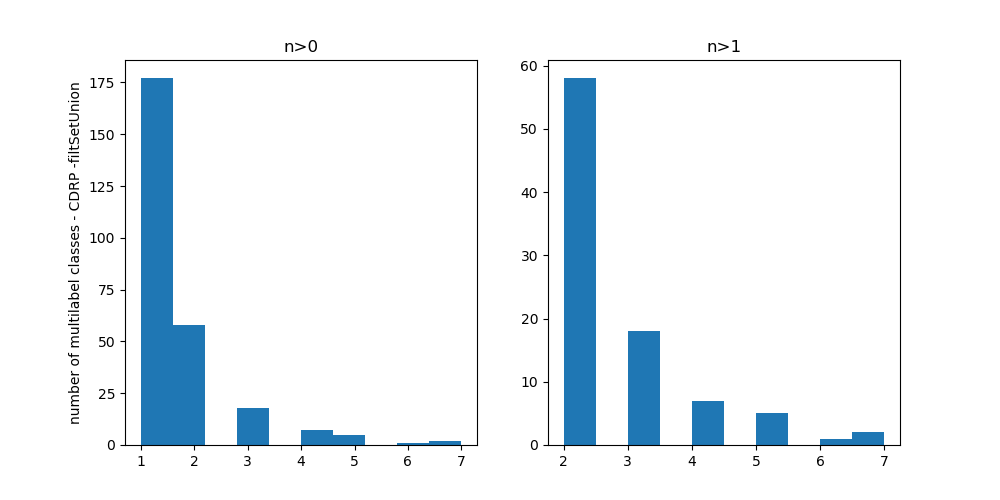

In [16]:
unq=mergProf_treatLevel['Metadata_MoA'].unique().tolist()
unq.remove(np.nan)
# n_multi_l=[len(u.split('|')) for u in unq if '|' in u]

fig, axes = plt.subplots(1,2,figsize=(10,5))

axes[0].hist([len(u.split('|')) for u in unq]);
axes[0].set_title('n>0');
axes[0].set_ylabel('number of multilabel classes - CDRP -filtSetUnion');

axes[1].hist([len(u.split('|')) for u in unq if '|' in u]);
axes[1].set_title('n>1');#axes[1].set_ylabel('number of multilabel classes');

#### Number of Samples with more than one label

<IPython.core.display.Javascript object>


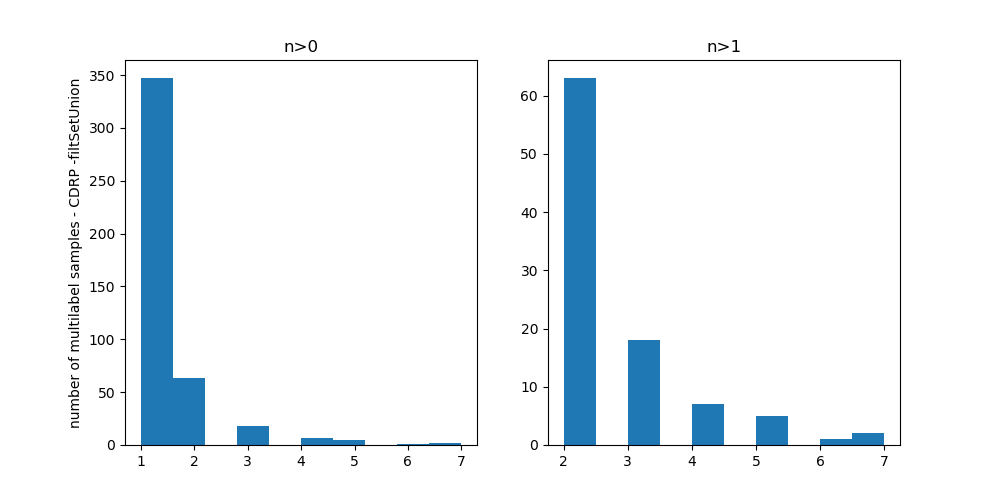

In [25]:
unq=mergProf_treatLevel['Metadata_MoA'].tolist()
unq=[u for u in unq if str(u) != 'nan']
# n_multi_l=[len(u.split('|')) for u in unq if '|' in u]

fig, axes = plt.subplots(1,2,figsize=(10,5))

axes[0].hist([len(u.split('|')) for u in unq]);
axes[0].set_title('n>0');axes[0].set_ylabel('number of multilabel samples - CDRP -filtSetUnion');

axes[1].hist([len(u.split('|')) for u in unq if '|' in u]);
axes[1].set_title('n>1');#axes[1].set_ylabel('number of multilabel samples');

In [21]:


# mergProf_treatLevel.columns[mergProf_treatLevel.columns.str.contains('moa')]
# # list(set(mergProf_treatLevel.columns.tolist())-set(cp_features))
unq

[nan,
 'dopamine receptor agonist',
 'chk inhibitor',
 'farnesyltransferase inhibitors',
 'cytotoxic lipid peroxidation product',
 nan,
 'protein synthesis inhibitor',
 'adenosine kinase inhibitor|nucleoside transporter inhibitor',
 nan,
 'gaba receptor modulator',
 'microtubule formation inhibitor|tubulin inhibitor|tubulin polymerisation inhibitor',
 'estrogen receptor agonist',
 'tubulin inhibitor|microtubule stabilizing agent|microtubule stimulant|p glycoprotein inhibitor|taxane',
 'gaba receptor antagonist|tp53 activator',
 'protein synthesis inhibitor',
 'calcium channel blocker',
 'atpase inhibitor',
 'dopamine receptor agonist',
 nan,
 nan,
 'p38 mapk inhibitor',
 nan,
 'atpase inhibitor',
 'protein phosphatase inhibitor',
 nan,
 nan,
 'hsp90 inhibitor',
 'protein phosphatase inhibitor',
 nan,
 nan,
 'atpase inhibitor',
 'ppar receptor agonist',
 'jak inhibitor|lipocortin synthesis stimulant|stat inhibitor',
 'plant alkaloid',
 nan,
 'adrenergic receptor agonist',
 'dopamine rec

In [75]:
mergProf_treatLevel[['Metadata_moa', 'Metadata_alternative_moa', 'moa',moa_col]]

,Metadata_moa,Metadata_alternative_moa,moa,Metadata_MoA
0,insulin sensitizer|PPAR receptor partial agonist,NaN,Insulin sensitizer|PPAR receptor partial agonist,insulin sensitizer|PPAR receptor partial agonist
1,insulin sensitizer|PPAR receptor partial agonist,NaN,Insulin sensitizer|PPAR receptor partial agonist,insulin sensitizer|PPAR receptor partial agonist
2,insulin sensitizer|PPAR receptor partial agonist,NaN,Insulin sensitizer|PPAR receptor partial agonist,insulin sensitizer|PPAR receptor partial agonist
3,insulin sensitizer|PPAR receptor partial agonist,NaN,Insulin sensitizer|PPAR receptor partial agonist,insulin sensitizer|PPAR receptor partial agonist
4,insulin sensitizer|PPAR receptor partial agonist,NaN,Insulin sensitizer|PPAR receptor partial agonist,insulin sensitizer|PPAR receptor partial agonist
...,...,...,...,...
6980,NaN,NaN,Potassium channel activator,potassium channel activator
6981,NaN,NaN,Potassium channel activator,potassium channel activator
6982,NaN,NaN,Potassium channel activator,potassium channel activator
6983,NaN,NaN,Potassium channel activator,potassium channel activator


In [31]:
mergProf_treatLevel[['Metadata_moa', 'Metadata_alternative_moa', 'moa',moa_col]]

,Metadata_moa,Metadata_alternative_moa,moa,Metadata_MoA
0,HSP inhibitor,NaN,HSP inhibitor,HSP inhibitor
1,HSP inhibitor,NaN,HSP inhibitor,HSP inhibitor
2,HSP inhibitor,NaN,HSP inhibitor,HSP inhibitor
3,HSP inhibitor,NaN,HSP inhibitor,HSP inhibitor
4,HSP inhibitor,NaN,HSP inhibitor,HSP inhibitor
...,...,...,...,...
1136,potassium channel activator,NaN,Potassium channel activator,potassium channel activator
1137,potassium channel activator,NaN,Potassium channel activator,potassium channel activator
1138,Abl kinase inhibitor|Bcr-Abl kinase inhibitor|...,NaN,Src inhibitor|Abl kinase inhibitor|Bcr-Abl kin...,Abl kinase inhibitor|Bcr-Abl kinase inhibitor|...
1139,NaN,NaN,Dopamine receptor antagonist,Dopamine receptor antagonist


In [21]:
mergProf_treatLevel[mergProf_treatLevel['Metadata_moa'].isnull()]['moa']

134                  Rho associated kinase inhibitor
135                  Rho associated kinase inhibitor
136                  Rho associated kinase inhibitor
137                  Rho associated kinase inhibitor
147                                   MTOR inhibitor
148                                   MTOR inhibitor
149                                   MTOR inhibitor
150                                   MTOR inhibitor
151                                   MTOR inhibitor
170                  Glucocorticoid receptor agonist
171                  Glucocorticoid receptor agonist
172                  Glucocorticoid receptor agonist
173                  Glucocorticoid receptor agonist
174                  Glucocorticoid receptor agonist
228     Methylmalonyl CoA mutase stimulant|Vitamin B
252                        Potassium channel blocker
394                  Benzodiazepine receptor agonist
465                  Rho associated kinase inhibitor
466                  Rho associated kinase inh

In [63]:
# mergProf_treatLevel[mergProf_treatLevel['Metadata_moa'].isnull()]['moa']

In [78]:
# mergProf_treatLevel[mergProf_treatLevel['Metadata_moa'].isnull()].shape

(195, 1103)

In [40]:
# mergProf_treatLevel[mergProf_treatLevel['Metadata_MoA'].isnull()].shape

In [48]:
# cp['Compounds'],cp['PERT']
pd.merge(nSamplesforEachMOAclass,nSamplesforEachMOAclass2,how='inner',on=[moa_col])

,Metadata_MoA,size_x,size_y
0,adrenergic receptor antagonist,33,165
1,phosphodiesterase inhibitor,32,159
2,cyclooxygenase inhibitor,31,154
3,histamine receptor antagonist,24,120
4,acetylcholine receptor antagonist,21,105
...,...,...,...
563,apoptosis stimulant,1,5
564,antiviral|RNA synthesis inhibitor,1,5
565,antiviral,1,5
566,antitumor agent|ribonucleotide reductase inhib...,1,5


In [56]:
# pd.concat([nSamplesforEachMOAclass,nSamplesforEachMOAclass2])
nSamplesforEachMOAclass

,Metadata_MoA,size
0,adrenergic receptor antagonist,33
1,phosphodiesterase inhibitor,32
2,cyclooxygenase inhibitor,31
3,histamine receptor antagonist,24
4,acetylcholine receptor antagonist,21
...,...,...
563,apoptosis stimulant,1
564,antiviral|RNA synthesis inhibitor,1
565,antiviral,1
566,antitumor agent|ribonucleotide reductase inhib...,1


/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


<IPython.core.display.Javascript object>


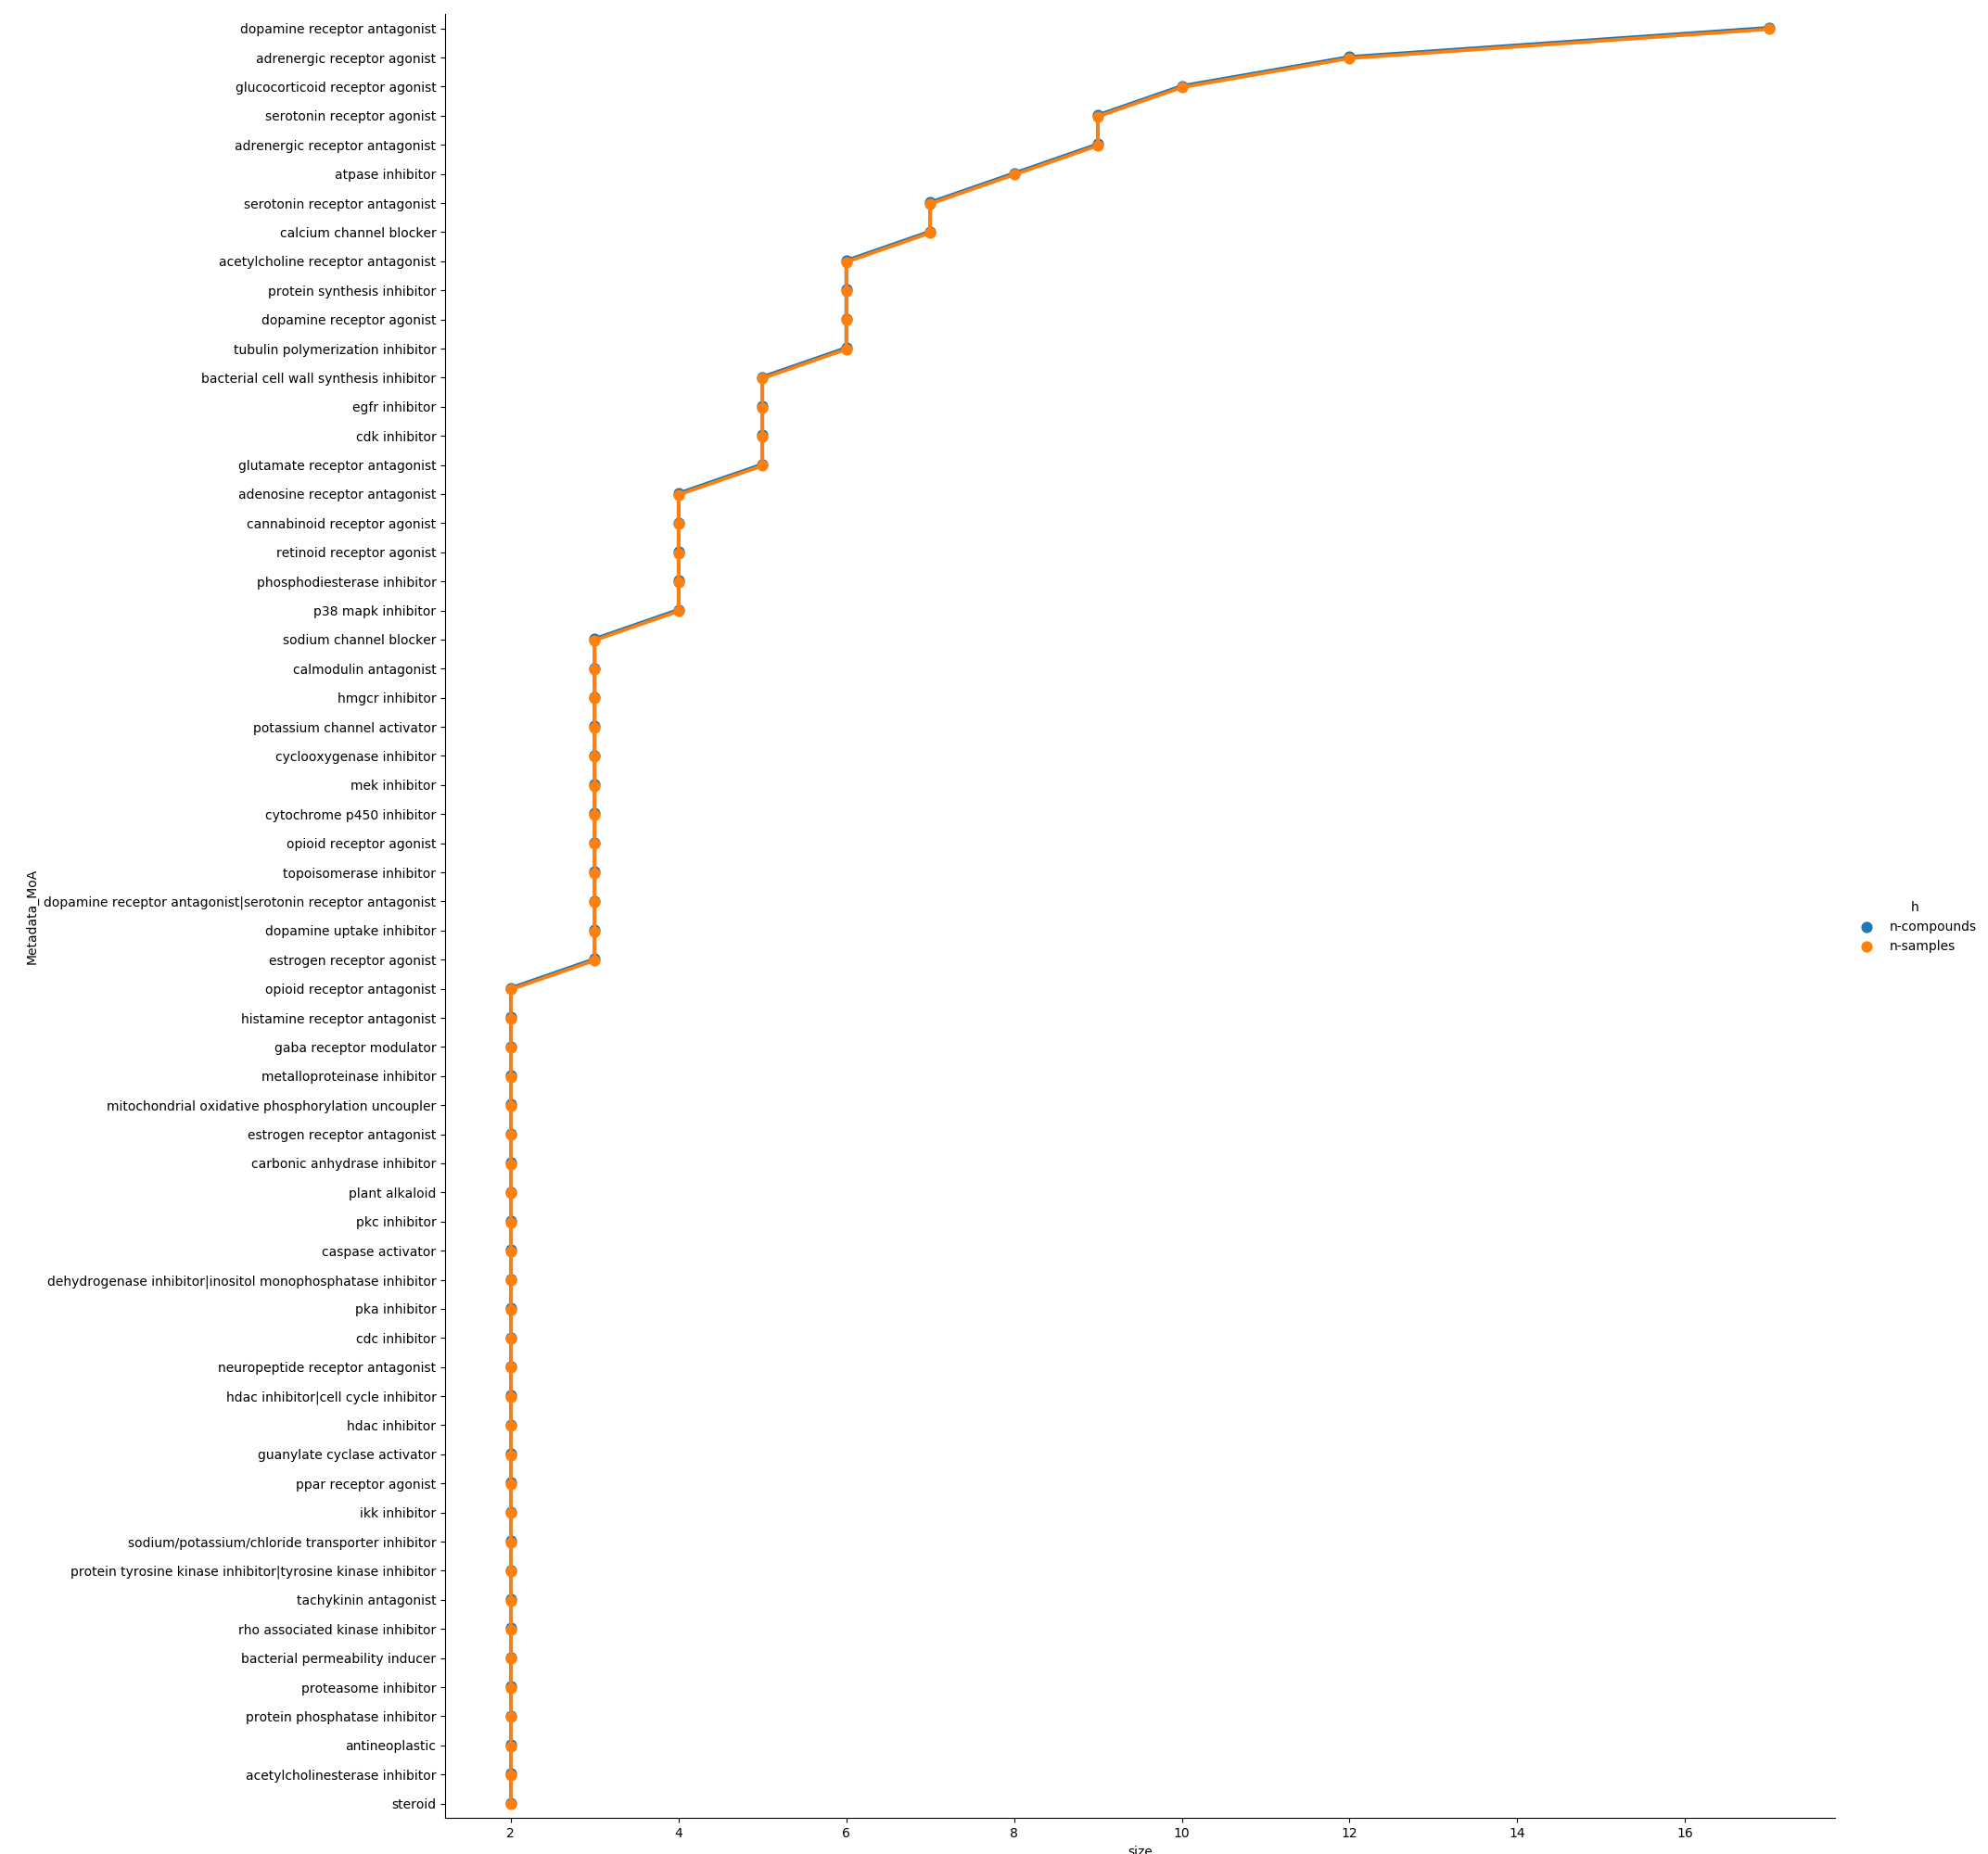

In [26]:
# plt.figure()
# fig, axes = plt.subplots(figsize=(20,5))
# nSamplesforEachMOAclass3=pd.merge(nSamplesforEachMOAclass,nSamplesforEachMOAclass2,how='inner',on=[moa_col])
nSamplesforEachMOAclass_=nSamplesforEachMOAclass[nSamplesforEachMOAclass['size']>1]
nSamplesforEachMOAclass2_=nSamplesforEachMOAclass2[nSamplesforEachMOAclass2[moa_col].isin(nSamplesforEachMOAclass_[moa_col].tolist())]
nSamplesforEachMOAclass_['h']='n-compounds'
nSamplesforEachMOAclass2_['h']='n-samples'

nSamplesforEachMOAclass3=pd.concat([nSamplesforEachMOAclass_,nSamplesforEachMOAclass2_])

sns.catplot(x="size",y=moa_col, data=nSamplesforEachMOAclass3[nSamplesforEachMOAclass3['size']>1],\
            orient="h", height=20, aspect=1,hue='h',
                kind="point", dodge=True, cut=0, bw=.2)
# fig.tight_layout()

In [58]:
# repp_df
nSamplesforEachMOAclass2[meta_col]

NameError: name 'meta_col' is not defined

In [139]:
# mergProf_treatLevel.groupby(['moa']).size().reset_index().rename(columns={0:'nrep'}).sort_values(by='nrep')
moa_col='moa'

In [26]:
nSamplesforEachMOAclass=mergProf_treatLevel.groupby(['Metadata_moa']).size().reset_index().rename(columns={0:'size'}).sort_values(by=['size'],ascending=False).reset_index(drop=True)
listOfSelectedMoAs=nSamplesforEachMOAclass[nSamplesforEachMOAclass['size']>1]['Metadata_moa'].tolist()
print(len(listOfSelectedMoAs))

179


In [27]:
# mergProf_treatLevel['Metadata_moa']=mergProf_treatLevel['Metadata_moa'].str.lower()
nSamplesforEachMOAclass=mergProf_treatLevel.groupby(['Metadata_moa']).size().reset_index().rename(columns={0:'size'}).sort_values(by=['size'],ascending=False).reset_index(drop=True)
listOfSelectedMoAs=nSamplesforEachMOAclass[nSamplesforEachMOAclass['size']>1]['Metadata_moa'].tolist()
print(len(listOfSelectedMoAs))

179


In [232]:
# listOfSelectedMoAs
# filteredMOAs['Metadata_moa_num']#=le.transform(filteredMOAs[moa_col].tolist())
filteredMOAs[moa_col].tolist()

['HSP inhibitor',
 'HSP inhibitor',
 'HSP inhibitor',
 'HSP inhibitor',
 'HSP inhibitor',
 'tubulin polymerization inhibitor',
 'tubulin polymerization inhibitor',
 'tubulin polymerization inhibitor',
 'tubulin polymerization inhibitor',
 'tubulin polymerization inhibitor',
 'adrenergic receptor antagonist',
 'glucocorticoid receptor agonist',
 'glucocorticoid receptor agonist',
 'glucocorticoid receptor agonist',
 'glucocorticoid receptor agonist',
 'glucocorticoid receptor agonist',
 'serotonin receptor agonist',
 'serotonin receptor agonist',
 'glucocorticoid receptor agonist',
 'glucocorticoid receptor agonist',
 'glucocorticoid receptor agonist',
 'glucocorticoid receptor agonist',
 'glucocorticoid receptor agonist',
 'adrenergic receptor antagonist',
 'adrenergic receptor antagonist',
 'glucocorticoid receptor agonist',
 'glucocorticoid receptor agonist',
 'glucocorticoid receptor agonist',
 'glucocorticoid receptor agonist',
 'glucocorticoid receptor agonist',
 'cyclooxygenase i

In [46]:
nSamplesforEachMOAclass

,Metadata_MoA,size
0,adrenergic receptor antagonist,33
1,phosphodiesterase inhibitor,32
2,cyclooxygenase inhibitor,31
3,histamine receptor antagonist,24
4,acetylcholine receptor antagonist,21
...,...,...
563,apoptosis stimulant,1
564,antiviral|RNA synthesis inhibitor,1
565,antiviral,1
566,antitumor agent|ribonucleotide reductase inhib...,1


In [1]:
# IDs4filteredMOAs

In [38]:
# nSamplesforEachMOAclass
# IDs4filteredMOAs
# pd.DataFrame(index=filteredMOAs['Compounds'].values,columns=['CP','GE','Early Fusion','Late Fusion'])
filteredMOAs.loc[test_index,'Compounds'].unique()[0]

'BRD-A03506276'

### MoA prediction using each dataset and early and late fusion of datasets

In [ ]:
from sklearn.metrics import f1_score
from sklearn.utils import class_weight
from sklearn.naive_bayes import GaussianNB,ComplementNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict, GroupKFold,LeaveOneGroupOut
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
# domXdata=merged_scaled.copy();
# domXfeats=data4eval[r][1]
# outdim_size=40

# filteredMOAs=domXdata[domXdata[pertColName].isin(IDs4filteredMOAs)].reset_index(drop=True)
# filteredMOAs['Metadata_moa_num']=le.transform(filteredMOAs[moa_col].tolist())
# cls_model='mlp'#'mlp';#'lr'
for cls_model in ['mlp']:
# for cls_model in ['mlp']:
    moa_pred_res=pd.DataFrame(index=filteredMOAs['Compounds'].values,columns=['CP','GE','Early Fusion',\
                                        'RGCCA_CP','RGCCA_GE','RGCCA_EarlyFusion','Late Fusion','Metadata_moa_num'])

    # n_of_random_sel=20
    # n_of_random_sel=50
    # n_folds=5
    # acc_array_fullSet2_cdrp=np.zeros((n_of_random_sel,4));
    # acc_array_filtSet2_cdrp=np.zeros((n_of_random_sel,4));
    # for i in range(n_of_random_sel):

    #     split_obj=GroupKFold(n_splits=k)
    # #     split_obj = LeaveOneGroupOut()    
    #     # Perform k-fold cross validation
    #     scores = cross_val_score(clf, X, y, groups=group_labels,cv=split_obj,n_jobs=n_j)

    # kf = KFold(n_splits=n_folds,random_state=1,shuffle=True)
    # gkf=GroupKFold(n_splits=n_folds)


    parameter_space_MLP = {
        'hidden_layer_sizes': [(100,),(200),(400)],
        'activation': ['tanh', 'relu'],
        'alpha': [0.0001,0.05],
    }

    # parameter_space_MLP = {
    #     'hidden_layer_sizes': [(10,30,10),(20,)],
    #     'activation': ['tanh', 'relu'],
    #     'solver': ['sgd', 'adam'],
    #     'alpha': [0.0001, 0.05],
    #     'learning_rate': ['constant','adaptive'],
    # }


    # parameter_space_logistic={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
    parameter_space_logistic={"C":[1,10,1000]}





    logo = LeaveOneGroupOut()

    leG = preprocessing.LabelEncoder()
    group_labels=leG.fit_transform(filteredMOAs['Compounds'].values)

    i=0
    # for train_index0, test_index in gkf.split(filteredMOAs, groups=group_labels):
    for train_index, test_index in logo.split(filteredMOAs, groups=group_labels):
        print('rand ',i)
        i+=1

    #     data_train = filteredMOAs.loc[train_index,domXfeats].values;
        labels_train=filteredMOAs.loc[train_index,'Metadata_moa_num'].tolist()
    #     print(filteredMOAs.loc[train_index,'Metadata_moa_num'].unique().shape)

    #     data_test = filteredMOAs.loc[test_index,domXfeats].values;
        labels_test=filteredMOAs.loc[test_index,'Metadata_moa_num'].tolist()
    #     print(filteredMOAs.loc[test_index,'Metadata_moa_num'].unique().shape)    

        class_weightt = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(labels_train),y=labels_train)    
    #         model_tr = RandomForestClassifier(n_estimators=10,max_features=100,class_weight="balanced")
#         sm1=RandomOverSampler(sampling_strategy='not majority',random_state=5)
        sm1=RandomOverSampler(sampling_strategy='not majority',random_state=5)
        probs=[]
        for n,dt_modality,col in zip([0,1,2,3,4,5],data4eval,['CP','GE','Early Fusion','RGCCA_CP','RGCCA_GE','RGCCA_EarlyFusion']):

            data_m=dt_modality[0]   

            dt_train=data_m.loc[train_index,dt_modality[1]].values;
            dt_test=data_m.loc[test_index,dt_modality[1]].values; 
        #         model_tr = RandomForestClassifier(n_estimators=10,max_features=100,class_weight="balanced")
    #         model_tr = GaussianNB()
    #         model_tr = ComplementNB()

    #         model_tr = RandomForestClassifier(n_estimators=10)

    #         model_logistic = LogisticRegression(multi_class='multinomial',max_iter=1000,class_weight="balanced")        
    #         model_tr = GridSearchCV(model_logistic, parameter_space_logistic, n_jobs=4, cv=2)

            if cls_model=='lr':
                model_logistic = LogisticRegression(multi_class='multinomial',class_weight="balanced")        
                model_tr = GridSearchCV(model_logistic, parameter_space_logistic, n_jobs=4, cv=2)

            elif cls_model=='mlp':
                
#                 model_tr = MLPClassifier(random_state=10,max_iter=600,alpha=0.0001,activation='tanh',hidden_layer_sizes=(200,))
                model_MLP = MLPClassifier(random_state=20,max_iter=600)
                model_tr = GridSearchCV(model_MLP, parameter_space_MLP, n_jobs=4, cv=2)

            dt_train_balanced,labels_train_balanced = sm1.fit_resample(dt_train,labels_train)

            model_tr.fit(dt_train_balanced,labels_train_balanced)        

#             print(model_tr.best_params_)
    #         accc=model_tr.score(dt_test,labels_test)
    #         print(model_tr.predict(dt_test))
    #         accc=f1_score(labels_test,model_tr.predict(dt_test), average='weighted')        
            moa_pred_res.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],col]=model_tr.predict(dt_test)
    #         moa_pred_res.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],col]=accc*100
            probs.append(model_tr.predict_proba(dt_test))

    #     labels_lateFusion=list(np.argmax((probs[0]+probs[1])/2,axis=1))
        labels_lateFusion=model_tr.classes_[np.argmax((probs[0]+probs[1])/2,axis=1)]
        moa_pred_res.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],'Late Fusion']=\
        labels_lateFusion
        moa_pred_res.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],'Metadata_moa_num']=\
        labels_test
    #     f1_score(labels_test,labels_lateFusion, average='weighted')*100
    #     accuracy_score(labels_test,labels_lateFusion)*100

    moa_pred_res['Metadata_moa_num']=moa_pred_res.Metadata_moa_num.apply(lambda x: int(x[0]) if type(x)==list else x)    
    print(moa_pred_res.mean())


    filename=results_dir+'/MoAprediction/pred_moa_CDRP.xlsx'
    saveAsNewSheetToExistingFile(filename,moa_pred_res,'fC-'+dataset+'-'+profTypeAbbrev+'-'+f+'-preds-'+cls_model+'-ht-5')

# print('Accuracy: ',r, np.mean(Acc_list)*100)  

#### StratifiedGroupKFold

In [ ]:
from sklearn.metrics import f1_score
from sklearn.utils import class_weight
from sklearn.naive_bayes import GaussianNB,ComplementNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict, GroupKFold,StratifiedGroupKFold
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import RandomOverSampler
# domXdata=merged_scaled.copy();
# domXfeats=data4eval[r][1]
# outdim_size=40

# filteredMOAs=domXdata[domXdata[pertColName].isin(IDs4filteredMOAs)].reset_index(drop=True)
# filteredMOAs['Metadata_moa_num']=le.transform(filteredMOAs[moa_col].tolist())

# cls_model='lr'#'mlp';#'lr'
for cls_model in ['mlp','lr']:
    moa_pred_res=pd.DataFrame(index=filteredMOAs.index,columns=['CP','GE','Early Fusion',\
                                        'RGCCA_CP','RGCCA_GE','RGCCA_EarlyFusion','Late Fusion','Metadata_moa_num'])


    moa_pred_res['PERT']=filteredMOAs['PERT']
    moa_pred_res['Compounds']=filteredMOAs['Compounds']

    # parameter_space_MLP = {
    #     'hidden_layer_sizes': [(50,),(100,),(200)],
    #     'activation': ['tanh'],
    #     'alpha': [0.0001],
    # }
    parameter_space_MLP = {
        'hidden_layer_sizes': [(100,),(200),(400)],
        'activation': ['tanh', 'relu'],
        'alpha': [0.0001,0.05],
        'learning_rate': ['constant','adaptive'],
    }

    # parameter_space_MLP = {
    #     'hidden_layer_sizes': [(10,30,10),(20,)],
    #     'activation': ['tanh', 'relu'],
    #     'solver': ['sgd', 'adam'],
    #     'alpha': [0.0001, 0.05],
    #     'learning_rate': ['constant','adaptive'],
    # }


    # parameter_space_logistic={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
    parameter_space_logistic={"C":[1,10,1000]}


    from sklearn.model_selection import GridSearchCV



    # logo = LeaveOneGroupOut()

    sgkf = StratifiedGroupKFold(n_splits=10,shuffle=True,random_state=1)

    leG = preprocessing.LabelEncoder()
    group_labels=leG.fit_transform(filteredMOAs['Compounds'].values)

    i=0
    # for train_index0, test_index in gkf.split(filteredMOAs, groups=group_labels):
    for train_index, test_index in sgkf.split(filteredMOAs,filteredMOAs['Metadata_moa_num'].values, groups=group_labels):
        print('rand ',i)
        i+=1

    #     data_train = filteredMOAs.loc[train_index,domXfeats].values;
        labels_train=filteredMOAs.loc[train_index,'Metadata_moa_num'].tolist()
    #     print(filteredMOAs.loc[train_index,'Metadata_moa_num'].unique().shape)

    #     data_test = filteredMOAs.loc[test_index,domXfeats].values;
        labels_test=filteredMOAs.loc[test_index,'Metadata_moa_num'].tolist()
    #     print(filteredMOAs.loc[test_index,'Metadata_moa_num'].unique().shape)    

    #     class_weightt = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(labels_train),y=labels_train)    
    #         model_tr = RandomForestClassifier(n_estimators=10,max_features=100,class_weight="balanced")

    #     overSampleMinorityFirstClassTo=np.max([labels_train.count(i) for i in set(labels_train)])

    #     ratios = {l: overSampleMinorityFirstClassTo for l in set(labels_train) \
    #       if labels_train.count(l)<overSampleMinorityFirstClassTo}
    #     sm1=RandomOverSampler(ratio=ratios)
        moa_pred_res.loc[test_index,'Fold']=i

        sm1=RandomOverSampler(sampling_strategy='not majority',random_state=5)

        probs=[]

        for n,dt_modality,col in zip([0,1,2,3,4,5],data4eval,['CP','GE','Early Fusion','RGCCA_CP',\
                    'RGCCA_GE','RGCCA_EarlyFusion','Fold']):


            data_m=dt_modality[0]

            dt_train=data_m.loc[train_index,dt_modality[1]].values;
            dt_test=data_m.loc[test_index,dt_modality[1]].values; 
        #         model_tr = RandomForestClassifier(n_estimators=10,max_features=100,class_weight="balanced")
    #         model_tr = GaussianNB()
    #         model_tr = ComplementNB()

    #         model_tr = RandomForestClassifier(n_estimators=10)

            if cls_model=='lr':
    #             model_tr = LogisticRegression(multi_class='multinomial',class_weight="balanced")        

                model_logistic = LogisticRegression(multi_class='multinomial',class_weight="balanced",n_jobs=4)        
                model_tr = GridSearchCV(model_logistic, parameter_space_logistic, n_jobs=4, cv=3)

            elif cls_model=='mlp':
    #             model_MLP = MLPClassifier(random_state=5,max_iter=100,alpha=0.0001,activation='tanh')
                model_MLP = MLPClassifier(random_state=5,max_iter=600)
                model_tr = GridSearchCV(model_MLP, parameter_space_MLP, n_jobs=4, cv=3)

            dt_train_balanced,labels_train_balanced = sm1.fit_resample(dt_train,labels_train)

            model_tr.fit(dt_train_balanced,labels_train_balanced)
    #         print(model_tr.best_params_)
    #         accc=model_tr.score(dt_test,labels_test)
    #         print(model_tr.predict(dt_test))
    #         accc=f1_score(labels_test,model_tr.predict(dt_test), average='weighted')        
            moa_pred_res.loc[test_index,col]=model_tr.predict(dt_test)
    #         moa_pred_res.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],col]=accc*100
            probs.append(model_tr.predict_proba(dt_test))

    #     labels_lateFusion=list(np.argmax((probs[0]+probs[1])/2,axis=1))
        labels_lateFusion=model_tr.classes_[np.argmax((probs[0]+probs[1])/2,axis=1)]
        moa_pred_res.loc[test_index,'Late Fusion']=\
        labels_lateFusion
        moa_pred_res.loc[test_index,'Metadata_moa_num']=\
        labels_test
    #     f1_score(labels_test,labels_lateFusion, average='weighted')*100
    #     accuracy_score(labels_test,labels_lateFusion)*100

    moa_pred_res['Metadata_moa_num']=moa_pred_res.Metadata_moa_num.apply(lambda x: int(x[0]) if type(x)==list else x)    
    print(moa_pred_res.mean())


    filename=results_dir+'/MoAprediction/pred_moa_CDRP.xlsx'
    saveAsNewSheetToExistingFile(filename,moa_pred_res,'fC-'+dataset+'-'+profTypeAbbrev+'-'+f+'-preds-'+cls_model+'-ht-sgkf-10f')


In [76]:
# len(indexes)
indexes[1].shape

(179,)

## Visualize the results

In [15]:
filename=results_dir+'/MoAprediction/pred_moa.xlsx'
saved_scores=pd.read_excel(filename, sheet_name=None)
saved_scores.keys()

dict_keys(['fC-LINCS-nvs-filt-preds-lr-ht', 'fC-LINCS-nvs-filt-preds-mlp-ht', 'fC-LINCS-nvs-filt-preds-lr-ht2', 'fCCA-LINCS-nvs-filt-preds-lr-ht2', 'fCCA-LINCS-nvs-filt-preds-mlp-ht2', 'fC-LINCS-nvs-filt-preds-mlp-ht2', 'fuseSNF-LINCS-nvs-filt-2', 'fC-CDRP-bio-nvs-filt-preds-lr-ht', 'fCCA-CDRP-bio-nvs-filt-preds-lr-ht', 'fC-CDRP-bio-nvs-filt-preds-mlp-ht', 'fCCA-CDRP-bio-nvs-filt-preds-mlp-ht'])

In [57]:
filename=results_dir+'/MoAprediction/pred_moa_CDRP.xlsx'
saved_scores_cdrpbio=pd.read_excel(filename, sheet_name=None)
saved_scores_cdrpbio.keys()


dict_keys(['fC-LINCS-nvs-filt-preds-lr-ht', 'fC-LINCS-nvs-filt-preds-mlp-ht', 'fC-LINCS-nvs-filt-preds-lr-ht2', 'fCCA-LINCS-nvs-filt-preds-lr-ht2', 'fCCA-LINCS-nvs-filt-preds-mlp-ht2', 'fC-LINCS-nvs-filt-preds-mlp-ht2', 'fuseSNF-LINCS-nvs-filt-2', 'fC-CDRP-bio-nvs-filt-preds-lr-ht', 'fCCA-CDRP-bio-nvs-filt-preds-lr-ht', 'fC-CDRP-bio-nvs-filt-preds-mlp-ht', 'fCCA-CDRP-bio-nvs-filt-preds-mlp-ht', 'fC-CDRP-bio-nvs-filt-preds-mlp-ht-2', 'fC-CDRP-bio-nvs-filt-preds-lr-ht-2', 'fC-CDRP-bio-nvs-filt-preds-lr-ht-3', 'fC-CDRP-bio-nvs-filt-preds-mlp-ht-3', 'fC-CDRP-bio-nvs-filt-preds-lr-ht-4', 'fC-CDRP-bio-nvs-filt-preds-mlp-ht-4', 'fC-CDRP-bio-nvs-filt-preds-lr-ht-5', 'fC-CDRP-bio-nvs-filt-preds-mlp-ht-5', 'fC-CDRP-bio-nvs-filt-preds-mlp-ht-sgkf', 'fC-CDRP-bio-nvs-filt-preds-lr-ht-sgkf', 'fC-CDRP-bio-nvs-filt-preds-mlp-ht-sgkf-1', 'fC-CDRP-bio-nvs-filt-preds-lr-ht-sgkf-1', 'fC-CDRP-bio-nvs-filt-preds-mlp-ht-sgkf-10f', 'fC-CDRP-bio-nvs-filt-preds-lr-ht-sgkf-10f'])

In [ ]:
#########################################################
res_df_cdrpbio=pd.DataFrame(columns=['Modality','Model'])
DS='CDRP-bio'
scores_mlp=saved_scores_cdrpbio['fC-'+DS+'-nvs-filt-preds-mlp-ht-sgkf-1']
# mofa_scores_2add=saved_scores['mofa-100fac'+DS+'-nvs-filt-preds-mlp-ht-2']
# scores_mlp['mofa']=mofa_scores_2add['mofa']

folds=scores_mlp['Fold'].unique().tolist()
for f in folds:
    scores_mlp_f=scores_mlp[scores_mlp['Fold']==f];
    for dd in ['CP', 'GE', 'Early Fusion', 'Late Fusion','RGCCA_EarlyFusion']:
        scor_vals=scores_mlp_f[dd].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    

        f1=f1_score(scor_vals,scores_mlp_f.Metadata_moa_num.values, average='macro')
        temp_df = pd.DataFrame(data={'Modality': [dd], 'Model': ['MLP'],'F1-score':[f1*100]})
        res_df_cdrpbio=res_df_cdrpbio.append(temp_df)
    
    
scores_mlp=saved_scores_cdrpbio['fC-'+DS+'-nvs-filt-preds-lr-ht-sgkf-1']
# mofa_scores_2add=saved_scores['mofa-100fac'+DS+'-nvs-filt-preds-lr-ht-2']
# scores_mlp['mofa']=mofa_scores_2add['mofa']

folds=scores_mlp['Fold'].unique().tolist()
for f in folds:
    scores_mlp_f=scores_mlp[scores_mlp['Fold']==f];
    # for dd in ['CP', 'GE', 'Early Fusion', 'Late Fusion','RGCCA_CP','RGCCA_GE','RGCCA_EarlyFusion']:
    for dd in ['CP', 'GE', 'Early Fusion', 'Late Fusion','RGCCA_EarlyFusion']:
        scor_vals=scores_mlp_f[dd].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    
        f1=f1_score(scores_mlp_f.Metadata_moa_num.values,scor_vals, average='macro')
        temp_df = pd.DataFrame(data={'Modality': [dd], 'Model': ['Logistic R'],'F1-score':[f1*100]})
        res_df_cdrpbio=res_df_cdrpbio.append(temp_df)


In [108]:
# scores_mlp[['Late Fusion','RGCCA_EarlyFusion']]

In [95]:
# report_clss

In [96]:
# report_clss

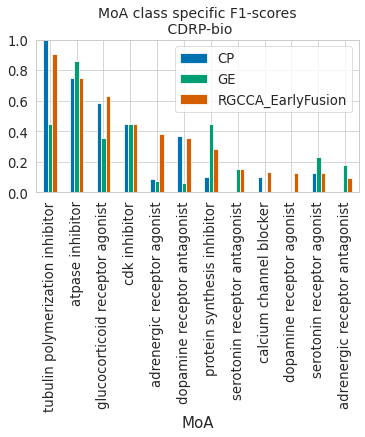

In [130]:
# report_clss_cp.loc[report_clss3.index]['f1-score']
%matplotlib inline
import matplotlib.style as style
style.use('seaborn-colorblind')
sns.set_style("whitegrid")
sns.set_context("paper",font_scale = 1.5, rc={"font.size":4,"axes.titlesize":14,"axes.labelsize":15})
report_clss3=report_clss2.sort_values(by='f1-score',ascending=False)
report_clss3['f1-score-cp']=report_clss_cp.loc[report_clss3.index]['f1-score'].values
report_clss3['f1-score-ge']=report_clss_ge.loc[report_clss3.index]['f1-score'].values
report_clss4=report_clss3[['f1-score-cp','f1-score-ge','f1-score']]
report_clss4=report_clss4.rename(columns={'f1-score-cp':'CP','f1-score-ge':'GE','f1-score':'RGCCA_EarlyFusion'})
report_clss4.index=report_clss3['MoA']
ax = report_clss4[report_clss4["RGCCA_EarlyFusion"]>0].plot.bar(rot=90,figsize=(5,6))
plt.title('MoA class specific F1-scores\n CDRP-bio')
ax.set_ylim([0,1])
plt.tight_layout()
# plt.savefig('moa_class_spacific_bar.eps')

In [131]:
report_clss4[report_clss4["RGCCA_EarlyFusion"]==0].shape

(4, 3)

In [117]:
report_clss4[report_clss4["RGCCA_EarlyFusion"]>0].index

Index(['tubulin polymerization inhibitor', 'atpase inhibitor',
       'glucocorticoid receptor agonist', 'cdk inhibitor',
       'adrenergic receptor agonist', 'dopamine receptor antagonist',
       'protein synthesis inhibitor', 'serotonin receptor antagonist',
       'calcium channel blocker', 'dopamine receptor agonist',
       'serotonin receptor agonist', 'adrenergic receptor antagonist'],
      dtype='object', name='MoA')

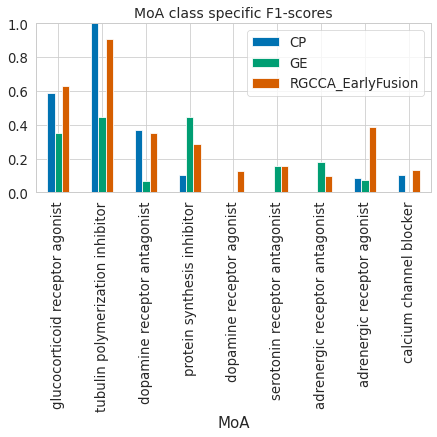

In [123]:
lincs_moa_top=['mTOR inhibitor', 'glucocorticoid receptor agonist', 'HSP inhibitor',
       'proteasome inhibitor', 'MEK inhibitor', 'HDAC inhibitor',
       'tubulin polymerization inhibitor', 'PLK inhibitor', 'EGFR inhibitor',
       'retinoid receptor agonist', 'CDK inhibitor', 'topoisomerase inhibitor',
       'p38 MAPK inhibitor', 'AKT inhibitor', 'serotonin receptor antagonist',
       'gamma secretase inhibitor', 'HMGCR inhibitor', 'PI3K inhibitor',
       'rho associated kinase inhibitor', 'cyclooxygenase inhibitor',
       'protein synthesis inhibitor', 'histamine receptor antagonist',
       'sterol demethylase inhibitor', 'PKC inhibitor',
       'dopamine receptor antagonist', 'adrenergic receptor antagonist',
       'vitamin D receptor agonist', 'acetylcholine receptor antagonist',
       'progesterone receptor agonist', 'dopamine receptor agonist',
       'benzodiazepine receptor agonist', 'phosphodiesterase inhibitor',
       'calcium channel blocker', 'adrenergic receptor agonist']

cdrp_moa_top=['tubulin polymerization inhibitor', 'atpase inhibitor',
       'glucocorticoid receptor agonist', 'cdk inhibitor',
       'adrenergic receptor agonist', 'dopamine receptor antagonist',
       'protein synthesis inhibitor', 'serotonin receptor antagonist',
       'calcium channel blocker', 'dopamine receptor agonist',
       'serotonin receptor agonist', 'adrenergic receptor antagonist']

# top_cdrp_lincs_overlap=list(set(lincs_moa_top) & set(cdrp_moa_top))
top_cdrp_lincs_overlap=['glucocorticoid receptor agonist',
 'tubulin polymerization inhibitor',
 'dopamine receptor antagonist',
 'protein synthesis inhibitor',
 'dopamine receptor agonist',
 'serotonin receptor antagonist',
 'adrenergic receptor antagonist',
 'adrenergic receptor agonist',
 'calcium channel blocker']

# ax = report_clss4[:15].plot.bar(rot=90,figsize=(7,7))
ax =report_clss4.loc[top_cdrp_lincs_overlap].plot.bar(rot=90,figsize=(6,6))
ax.set_ylim([0,1])
plt.title('MoA class specific F1-scores')
plt.tight_layout()

In [122]:
# report_clss4.loc[top_cdrp_lincs_overlap]
top_cdrp_lincs_overlap

['dopamine receptor agonist',
 'glucocorticoid receptor agonist',
 'tubulin polymerization inhibitor',
 'adrenergic receptor antagonist',
 'adrenergic receptor agonist',
 'protein synthesis inhibitor',
 'serotonin receptor antagonist',
 'calcium channel blocker',
 'dopamine receptor antagonist']

In [261]:
report_clss2['support']=report_clss2['support'].astype(int)
report_clss2['n_samples']=report_clss2['support']

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


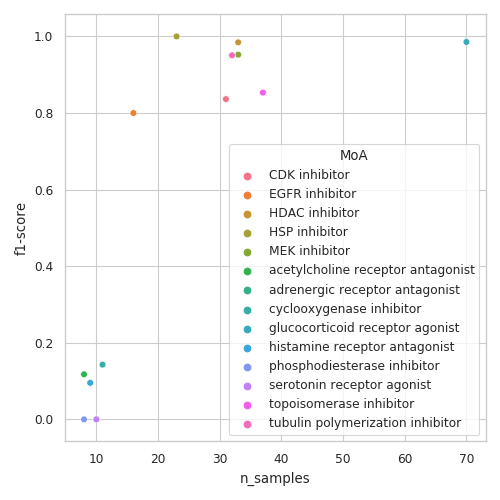

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [273]:

plt.figure(figsize=(5,5))
import matplotlib.style as style
style.use('seaborn-colorblind')
sns.scatterplot(data=report_clss2, x="n_samples", y="f1-score", hue="MoA",legend=True)
plt.tight_layout()# p
plt.savefig('moa_class_scatter.eps')

/home/ubuntu/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  app.launch_new_instance()


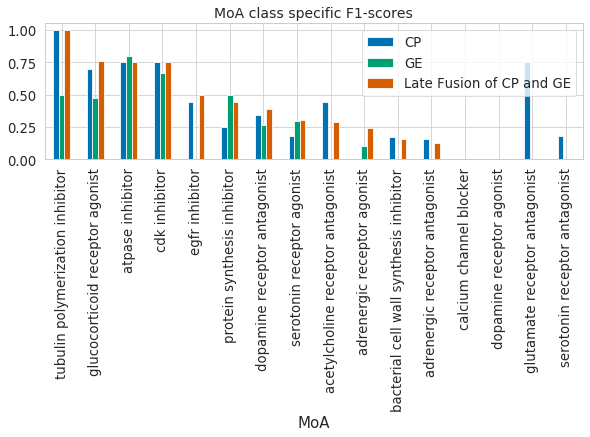

In [19]:
from sklearn.metrics import classification_report
scores_mlp=saved_scores['fC-CDRP-bio-nvs-filt-preds-mlp-ht']
scor_vals=scores_mlp['Late Fusion'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    
scor_vals_cp=scores_mlp['CP'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    
scor_vals_ge=scores_mlp['GE'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    

report_clss=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals.values,output_dict=True)).transpose()
report_clss_cp=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_cp.values,output_dict=True)).transpose()
report_clss_ge=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_ge.values,output_dict=True)).transpose()

# report_clss[list(range(13))]
# n_classes=14
n_classes=16
report_clss['MoA']=''
# report_clss
report_clss.loc[0:n_classes,'MoA']=le.inverse_transform(list(range(n_classes)))
report_clss2=report_clss[0:n_classes]

report_clss3=report_clss2.sort_values(by='f1-score',ascending=False)
report_clss3['f1-score-cp']=report_clss_cp.loc[report_clss3.index]['f1-score'].values
report_clss3['f1-score-ge']=report_clss_ge.loc[report_clss3.index]['f1-score'].values
report_clss4=report_clss3[['f1-score-cp','f1-score-ge','f1-score']]
report_clss4=report_clss4.rename(columns={'f1-score-cp':'CP','f1-score-ge':'GE','f1-score':'Late Fusion of CP and GE'})
report_clss4.index=report_clss3['MoA']
ax = report_clss4.plot.bar(rot=90,figsize=(8,6))
plt.title('MoA class specific F1-scores')
plt.tight_layout()
# plt.savefig('moa_class_spacific_bar.eps')

In [82]:
described_data=DataFuseResults_filt2.groupby([moa_col]).describe()